In [156]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [157]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [158]:
print('total number of unique Ids:',train['Patient-Uid'].nunique())
print('total number of unique Incident:',train['Incident'].nunique())

total number of unique Ids: 27033
total number of unique Incident: 57


In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


### Data Sampling

In [160]:
df = train.copy()
x = pd.get_dummies(df['Incident'])
df = df.drop('Incident',axis=1).join(x).drop(['PRIMARY_DIAGNOSIS','TARGET DRUG'],axis=1)
df = df.groupby('Patient-Uid').sum()

In [161]:
x = df.loc['a0db1e73-1c7c-11ec-ae39-16262ee38c7f'].index # just to get total number of columns 
# Below code finds differents types of Drugs , Symptoms and test occured in Incident for each Patient
total_d = []
total_s = []
total_t = []
for i in df.index:
    D_types = []
    S_types = []
    T_types = []
    a = df.loc[i]
    for j in range(len(x)):
        if a[j]>0:
            if a.index[j][0]=='D':
                D_types.append(x[j])
            
            elif a.index[j][0]=='S':
                S_types.append(x[j])
            
            else:
                T_types.append(x[j])
                
        else :
            continue
    
    total_d.append(len(D_types))
    total_s.append(len(S_types))
    total_t.append(len(T_types))

In [162]:
data = train.drop('Date',axis=1)
data['Tota_Incidences'] = 1
data['year'] = train['Date'].dt.year
data['month'] = train['Date'].dt.month

In [163]:
data['Incident_1'] = data['Incident'].str.replace(r'SYMPTOM_TYPE_[0-9]?[0-9]','S')
data['Incident_1'] = data['Incident_1'].str.replace(r'DRUG_TYPE_[0-9]?[0-9]','D')
data['Incident_1'] = data['Incident_1'].str.replace(r'TEST_TYPE_[0-9]?[0-9]','T')

In [164]:
# Below code finds total months and averages instances per year
mean_incidences_per_year = []
x = data.groupby(['Patient-Uid','year']).sum()
for i in df.index:
    mean_incidences_per_year.append(x.loc[i].mean()[0])
                                    
total_months = []
x = data.groupby(['Patient-Uid','year','month']).sum()
for i in df.index:
    total_months.append(len(x.loc[i].index))                             

In [165]:
data_x = data.drop(['year','Incident','month'],axis=1).copy()
x = pd.get_dummies(data_x['Incident_1'])
data_x = data_x.drop('Incident_1',axis=1).join(x)
data_x = data_x.groupby('Patient-Uid').sum()
data_x['Total_diff_symp'] = total_s
data_x['Total_incidences_per_year'] = mean_incidences_per_year
data_x['Total_diff_drug'] = total_d
data_x['Total_diff_test'] = total_t
data_x['total_month'] = total_months
#data_x['Avg_sum_month_total_year'] = avg_sum_mon

In [166]:
# Below code is performed to conserve the data loss due to groupby to find the fluctuations in the datasets by creating new Features
data_x['Total_drugs_per_incidences'] = data_x['D']/data_x['Tota_Incidences']
data_x['Total_symptoms_per_Incidences'] = data_x['S']/data_x['Tota_Incidences']
data_x['Total_incidneces_per_mon'] = data_x['Tota_Incidences']/data_x['total_month']
data_x['Total_drug_per_month'] = data_x['D']/data_x['total_month']
data_x['Total_symptoms_per_month'] = data_x['S']/data_x['total_month']
data_x['Total_drug_next_mon'] = data_x['D']+data_x['Total_drug_per_month']
data_x['Total_symptoms_next_mon'] = data_x['S']+data_x['Total_symptoms_per_month']

In [167]:
from sklearn.cluster import KMeans,DBSCAN
kmeans = KMeans(n_clusters=2,random_state=42).fit(data_x)
labels = kmeans.labels_
data_x['Labels'] = labels

In [168]:
print('Total Previsously taken Target drugs for label 0',sum(data_x[data_x['Labels']==0]['TARGET DRUG']>=1))
print('Total Previsously taken Target drugs for label 1',sum(data_x[data_x['Labels']==1]['TARGET DRUG']>=1))
data_x['Labels'] = 1-data_x['Labels'] # just to make labels change as 1 is for positive and 0 is for negative
# Above what I have done is 0 had most previously takne so i changed it to 1
data_x.drop('TARGET DRUG',axis=1,inplace=True)
x_train = data_x.copy()

Total Previsously taken Target drugs for label 0 6299
Total Previsously taken Target drugs for label 1 3075


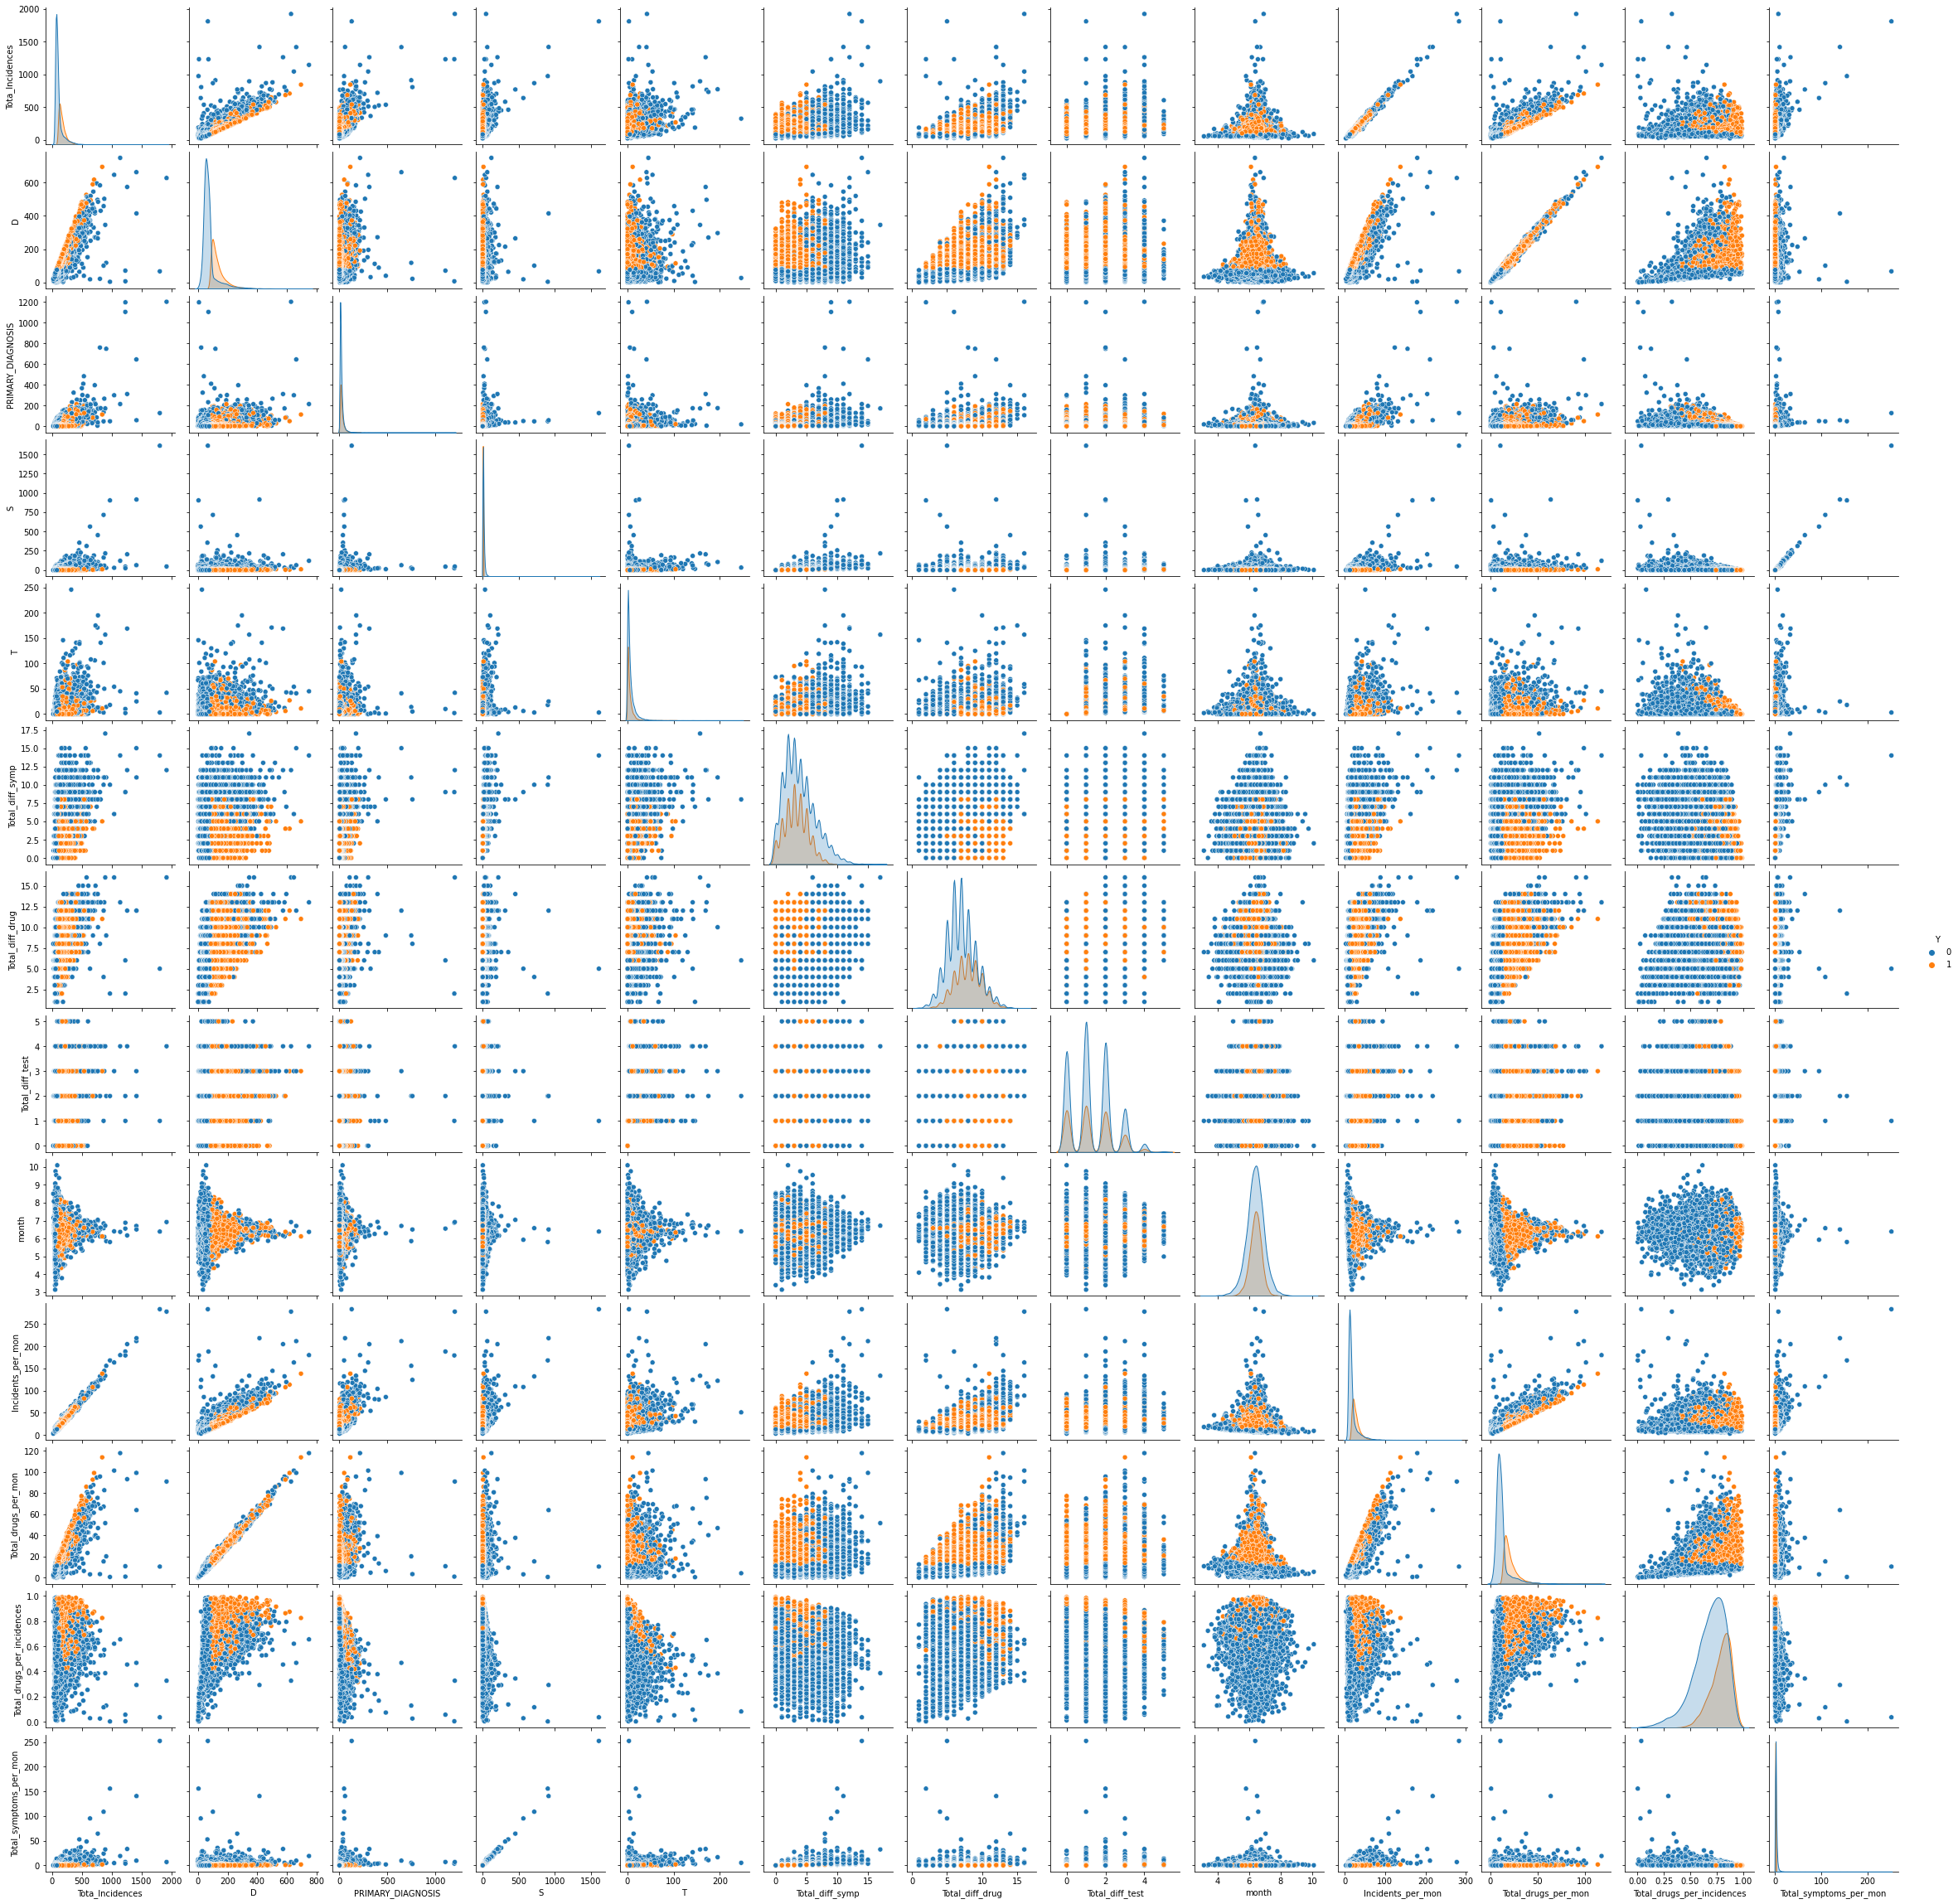

In [140]:
sns.pairplot(x_train,hue='Y')

### Model Building and Preprocessing

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,make_scorer
from sklearn.pipeline import Pipeline

In [171]:
X = x_train.drop('Labels',axis=1)
y = x_train['Labels']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.3)

In [183]:
def model(steps,params,X,y):
    
    pipeline = Pipeline(steps)
    gv_model = GridSearchCV(pipeline,param_grid=params,cv=3)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42, shuffle = True)
    gv_model.fit(X_train,y_train)
    
    y_pred_train = gv_model.predict(X_train)
    y_pred_test = gv_model.predict(X_test)
    
    
    cross_val = cross_val_score(gv_model,X,y,cv=3)
    
    params = {
        'y_pred_train':y_pred_train,
        'y_pred_test':y_pred_test,
        'y_train':y_train,
        'y_test':y_test,
        'model':gv_model,
        'cross_val':cross_val
    }
    
    return params

In [185]:
# SVC 
steps = [('scaler',StandardScaler()),('svc',SVC(kernel='poly'))]
params = {'svc__C':[0.5,1,2],'svc__degree':[4,5,6]}

par_svc = model(steps,params,X,y)
train_predict = par_svc['model'].predict(X_train)
test_predict = par_svc['model'].predict(X_test)
print(confusion_matrix(y_test,test_predict))
print('Accuracy for Test:',accuracy_score(y_test,test_predict))

array([[1405,   88],
       [   6, 6611]], dtype=int64)

In [187]:
#Random Forest
steps = [('rf',RandomForestClassifier())]
params = {'rf__n_estimators':[150,200,250],
          'rf__max_depth':[4,5],
          'rf__min_samples_split':[2],
          'rf__min_samples_leaf':[3],
          'rf__n_jobs':[-1]
         }
par_rf = model(steps,params,X,y)
train_predict = par_rf['model'].predict(X_train)
test_predict = par_rf['model'].predict(X_test)
print(confusion_matrix(y_test,test_predict))
print('Accuracy for Test:',accuracy_score(y_test,test_predict))

[[1479   14]
 [  10 6607]]
Accuracy for Test: 0.9970406905055487


In [188]:
# Gradient Boosting
steps = [('gbt',GradientBoostingClassifier())]
params = {
    'gbt__n_estimators':[50],
    'gbt__learning_rate':[0.1,0.5],
    'gbt__max_depth':[2,3],
    'gbt__min_samples_split':[3],
    'gbt__max_features':['log2','sqrt']
}
par_gbt = model(steps,params,X,y)
train_predict = par_gbt['model'].predict(X_train)
test_predict = par_gbt['model'].predict(X_test)
print(confusion_matrix(y_test,test_predict))
print('Accuracy for Test:',accuracy_score(y_test,test_predict))

[[1483   10]
 [   7 6610]]
Accuracy for Test: 0.9979038224414304


In [200]:
# XGBoosting
steps = [('xgb',XGBClassifier())]
params = {
    'xgb__n_estimators':[120],
    'xgb__learning_rate':[0.08],
    'xgb__max_depth':[2,3],
    'xgb__gamma':[1]
}
par_xgb =  model(steps,params,X,y)
train_predict = par_xgb['model'].predict(X_train)
test_predict = par_xgb['model'].predict(X_test)
print(confusion_matrix(y_test,test_predict))
print('Accuracy for Test:',accuracy_score(y_test,test_predict))

[17:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Working on Test Dataset

In [141]:
df = test.copy()
x = pd.get_dummies(df['Incident'])
df = df.drop('Incident',axis=1).join(x).drop('PRIMARY_DIAGNOSIS',axis=1)
df = df.groupby('Patient-Uid').sum()

In [144]:
x = df.loc['a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f'].index # just to get total number of columns 
# Below code finds differents types of Drugs , Symptoms and test occured in Incident for each Patient
total_d = []
total_s = []
total_t = []
for i in df.index:
    D_types = []
    S_types = []
    T_types = []
    a = df.loc[i]
    for j in range(len(x)):
        if a[j]>0:
            if a.index[j][0]=='D':
                D_types.append(x[j])
            
            elif a.index[j][0]=='S':
                S_types.append(x[j])
            
            else:
                T_types.append(x[j])
                
        else :
            continue
    
    total_d.append(len(D_types))
    total_s.append(len(S_types))
    total_t.append(len(T_types))

In [146]:
data = test.drop('Date',axis=1)
data['Tota_Incidences'] = 1
data['year'] = test['Date'].dt.year
data['month'] = test['Date'].dt.month

In [147]:
data['Incident_1'] = data['Incident'].str.replace(r'SYMPTOM_TYPE_[0-9]?[0-9]','S')
data['Incident_1'] = data['Incident_1'].str.replace(r'DRUG_TYPE_[0-9]?[0-9]','D')
data['Incident_1'] = data['Incident_1'].str.replace(r'TEST_TYPE_[0-9]?[0-9]','T')

In [148]:
mean_incidences_per_year = []
x = data.groupby(['Patient-Uid','year']).sum()
for i in df.index:
    mean_incidences_per_year.append(x.loc[i].mean()[0])
                                    
total_months = []
x = data.groupby(['Patient-Uid','year','month']).sum()
for i in df.index:
    total_months.append(len(x.loc[i].index))

In [149]:
data_x = data.drop(['year','Incident','month'],axis=1).copy()
x = pd.get_dummies(data_x['Incident_1'])
data_x = data_x.drop('Incident_1',axis=1).join(x)
data_x = data_x.groupby('Patient-Uid').sum()
data_x['Total_diff_symp'] = total_s
data_x['Total_incidences_per_year'] = mean_incidences_per_year
data_x['Total_diff_drug'] = total_d
data_x['Total_diff_test'] = total_t
data_x['total_month'] = total_months

In [151]:
data_x['Total_drugs_per_incidences'] = data_x['D']/data_x['Tota_Incidences']
data_x['Total_symptoms_per_Incidences'] = data_x['S']/data_x['Tota_Incidences']
data_x['Total_incidneces_per_mon'] = data_x['Tota_Incidences']/data_x['total_month']
data_x['Total_drug_per_month'] = data_x['D']/data_x['total_month']
data_x['Total_symptoms_per_month'] = data_x['S']/data_x['total_month']
data_x['Total_drug_next_mon'] = data_x['D']+data_x['Total_drug_per_month']
data_x['Total_symptoms_next_mon'] = data_x['S']+data_x['Total_symptoms_per_month']

In [153]:
test_y = data_x.copy()

In [201]:
predict_test = par_xgb['model'].predict(test_y)

In [208]:
df = pd.DataFrame(predict_test,index=test_y.index)

In [213]:
df.to_csv('submission_final.csv',index=True)

In [214]:
len(predict_test)

11482